In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
==============================linear-fstw
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


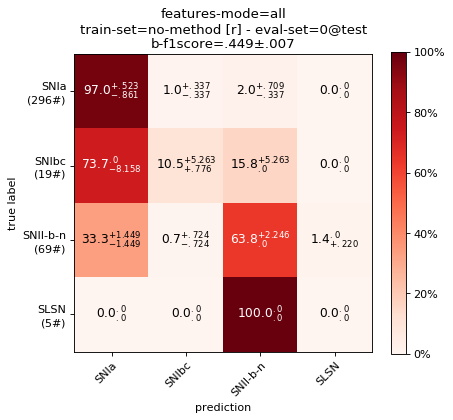

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0472
[2#] SPM_gamma_r=.0428
[3#] LinearTrend_g=.0383
[4#] SPM_t0_r=.0355
[5#] LinearTrend_r=.0286
[6#] ExcessVar_r=.0274
[7#] SPM_tau_fall_r=.0257
[8#] SPM_tau_fall_g=.0244
[9#] Meanvariance_r=.0242
[10#] SPM_tau_rise_r=.0236
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


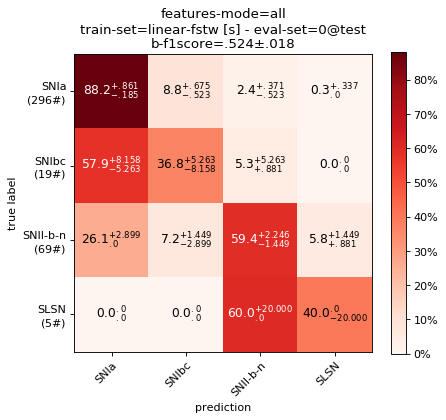

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0565
[2#] SPM_t0_r=.0417
[3#] LinearTrend_g=.0374
[4#] LinearTrend_r=.0291
[5#] SPM_tau_rise_r=.0279
[6#] SPM_gamma_r=.0275
[7#] SPM_tau_fall_r=.0243
[8#] Meanvariance_r=.0235
[9#] ExcessVar_r=.0222
[10#] SPM_gamma_g=.0211
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


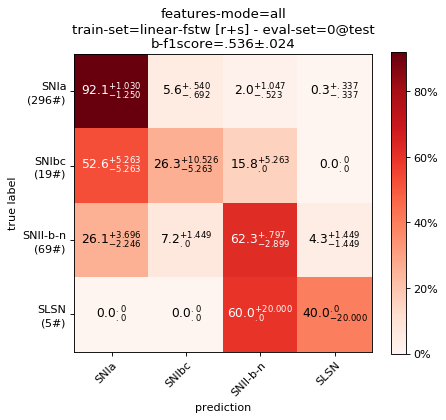

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0548
[2#] SPM_t0_r=.0438
[3#] SPM_gamma_r=.0330
[4#] LinearTrend_r=.0318
[5#] LinearTrend_g=.0317
[6#] Meanvariance_r=.0278
[7#] SPM_tau_fall_g=.0267
[8#] ExcessVar_r=.0243
[9#] SPM_tau_rise_r=.0241
[10#] SPM_gamma_g=.0236
==============================bspline-fstw
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


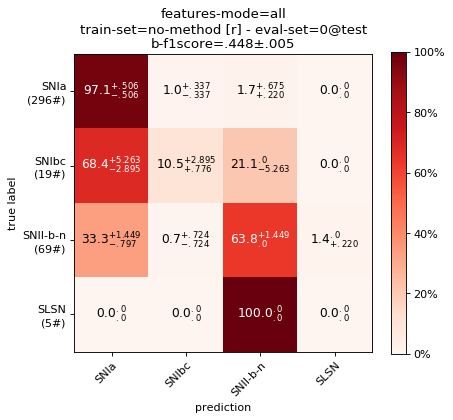

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0470
[2#] SPM_gamma_r=.0426
[3#] LinearTrend_g=.0397
[4#] SPM_t0_r=.0341
[5#] LinearTrend_r=.0337
[6#] SPM_tau_rise_r=.0271
[7#] ExcessVar_r=.0260
[8#] SPM_tau_fall_r=.0256
[9#] SPM_gamma_g=.0256
[10#] Meanvariance_r=.0253
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


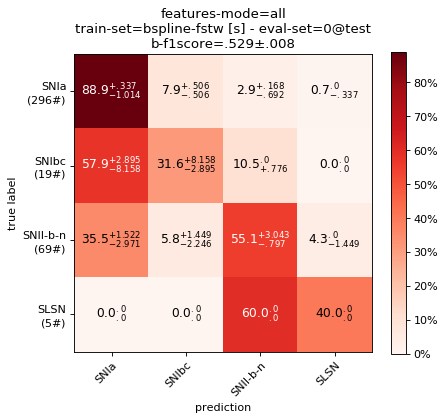

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0501
[2#] LinearTrend_g=.0442
[3#] LinearTrend_r=.0342
[4#] SPM_t0_r=.0318
[5#] SPM_gamma_r=.0316
[6#] SPM_tau_rise_r=.0271
[7#] SPM_gamma_g=.0250
[8#] ExcessVar_r=.0234
[9#] Meanvariance_r=.0225
[10#] SPM_tau_fall_g=.0170
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


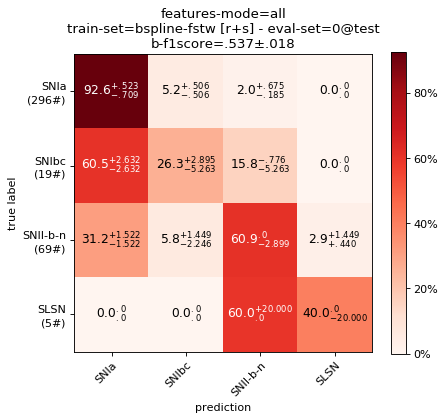

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0520
[2#] LinearTrend_g=.0409
[3#] SPM_t0_r=.0382
[4#] LinearTrend_r=.0363
[5#] SPM_gamma_r=.0322
[6#] SPM_gamma_g=.0272
[7#] Meanvariance_r=.0260
[8#] SPM_tau_rise_r=.0250
[9#] ExcessVar_r=.0240
[10#] SPM_tau_fall_g=.0223
==============================spm-mcmc-fstw
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


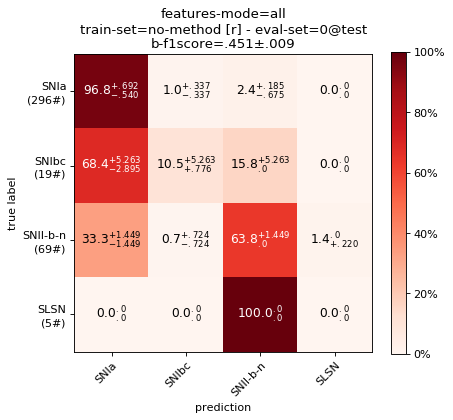

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0460
[2#] SPM_gamma_r=.0452
[3#] LinearTrend_g=.0391
[4#] LinearTrend_r=.0340
[5#] SPM_t0_r=.0337
[6#] ExcessVar_r=.0263
[7#] SPM_gamma_g=.0262
[8#] SPM_tau_fall_r=.0250
[9#] SPM_tau_rise_r=.0245
[10#] Meanvariance_r=.0245
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


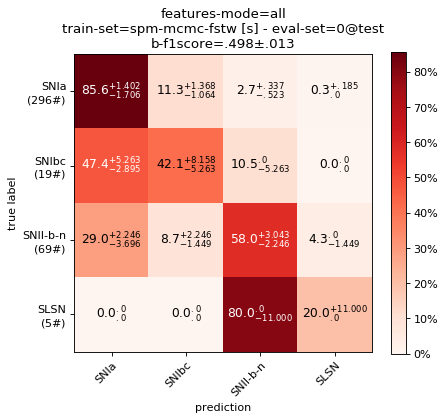

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0560
[2#] SPM_t0_r=.0410
[3#] LinearTrend_g=.0405
[4#] SPM_gamma_r=.0349
[5#] LinearTrend_r=.0283
[6#] SPM_tau_rise_r=.0254
[7#] ExcessVar_r=.0235
[8#] SPM_tau_fall_r=.0228
[9#] Meanvariance_r=.0227
[10#] SPM_gamma_g=.0218
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


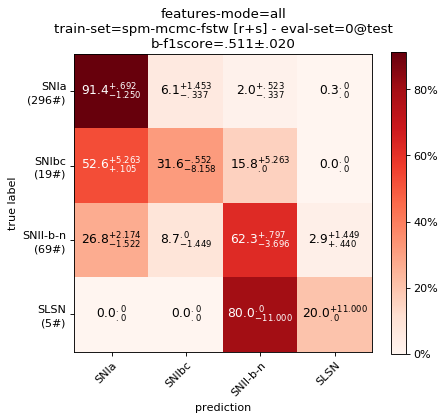

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0551
[2#] SPM_t0_r=.0418
[3#] LinearTrend_g=.0373
[4#] SPM_gamma_r=.0340
[5#] LinearTrend_r=.0306
[6#] SPM_tau_rise_r=.0279
[7#] SPM_tau_fall_r=.0256
[8#] SPM_tau_fall_g=.0244
[9#] Meanvariance_r=.0238
[10#] ExcessVar_r=.0233
==============================spm-mcmc-estw
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


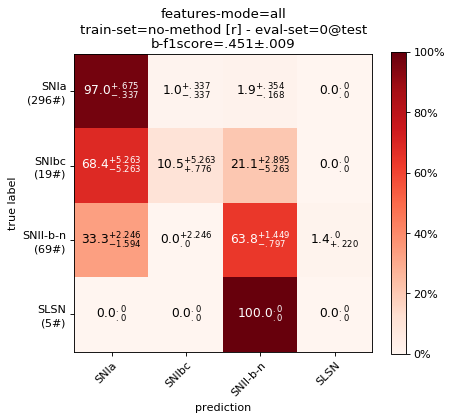

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0477
[2#] SPM_gamma_r=.0424
[3#] SPM_t0_r=.0374
[4#] LinearTrend_r=.0361
[5#] LinearTrend_g=.0322
[6#] ExcessVar_r=.0256
[7#] Meanvariance_r=.0247
[8#] SPM_gamma_g=.0247
[9#] SPM_tau_fall_g=.0245
[10#] SPM_beta_r=.0244
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


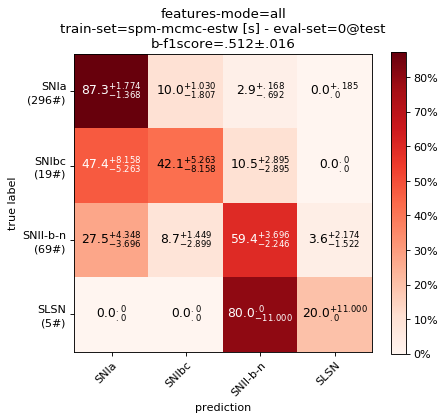

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0519
[2#] SPM_t0_r=.0391
[3#] SPM_gamma_r=.0349
[4#] LinearTrend_g=.0341
[5#] SPM_tau_rise_r=.0304
[6#] LinearTrend_r=.0287
[7#] SPM_gamma_g=.0258
[8#] SPM_tau_fall_r=.0258
[9#] Meanvariance_r=.0239
[10#] SPM_tau_fall_g=.0217
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


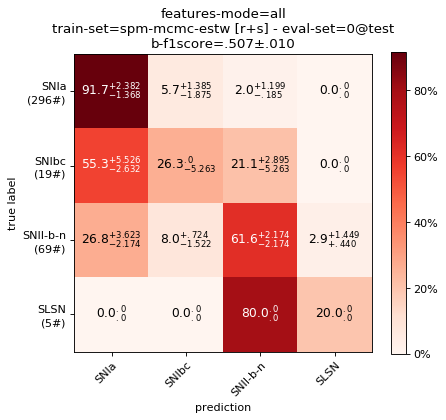

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0516
[2#] SPM_gamma_r=.0397
[3#] SPM_t0_r=.0363
[4#] LinearTrend_g=.0340
[5#] SPM_tau_rise_r=.0292
[6#] LinearTrend_r=.0292
[7#] SPM_tau_fall_g=.0257
[8#] Meanvariance_r=.0246
[9#] SPM_tau_fall_r=.0245
[10#] SPM_gamma_g=.0223


In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import search_for_filedirs, gather_files_by_kfold
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
import matplotlib.pyplot as plt
from flamingchoripan.datascience.xerror import XError
from IPython.display import display

def get_kf_text(set_name, kf):
    if kf=='.':
        return f'($\\mu\\pm\\sigma$ from 5-fold cross-validation in {set_name}-set)'
    else:
        return f'($\\mu\\pm\\sigma$ from {kf} k-fold in {set_name}-set)'

def get_mode_text(mode, features):
    if mode=='sne':
        return f'Using {len(features)} SNe selected astrophysical features'
    else:
        return f'Using {len(features)} astrophysical features'
    
mode = 'all' # sne all
methods = [
    'linear-fstw',
    'bspline-fstw',
    #'spm-mle-fstw',
    'spm-mcmc-fstw',
    #'spm-mle-estw',
    'spm-mcmc-estw',
]
#methods = ['spm-mcmc-estw']
eval_lcset_name = 'test'
kf = '0'

for method in methods:
    print('='*30+method)
    #for train_config in ['r', 's']:
    for train_config in ['r', 's', 'r+s']:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        features = files[0]()['features']
        cms = np.concatenate([f()['cm'][None] for f in files], axis=0)
        bprecision_xe = XError([f()['metrics_dict']['b-precision'] for f in files])
        brecall_xe = XError([f()['metrics_dict']['b-recall'] for f in files])
        bf1score_xe = XError([f()['metrics_dict']['b-f1score'] for f in files])

        ### plot cm
        _title = 'no-method [r]' if train_config=='r' else f'{method} [{train_config}]'
        title = ''
        title += f'features-mode={mode}'+'\n'
        title += f'train-set={_title} - eval-set={kf}@{eval_lcset_name}'+'\n'
        #title += f'b-p/r={bprecision_xe} / {brecall_xe}'+'\n'
        title += f'b-f1score={bf1score_xe}'+'\n'
        cm_kwargs = {
            'title':title[:-1],
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'SNII-b-n', 'SLSN'],
        }
        fig, ax, cm_norm = plot_custom_confusion_matrix(cms, class_names, **cm_kwargs)
        #accu = XError(np.diagonal(cm_norm*100, axis1=1, axis2=2).flatten().tolist())
        #title += f'b-accu={accu}'+'\n'
        #ax.set_title(title[:-1])
        #print(files[0]()['features'])
        caption = ''
        caption += f'Confusion matrix.'
        caption += f' {get_mode_text(mode, features)} {get_kf_text(eval_lcset_name, kf)}'
        print(caption)
        plt.show()
        #assert 0
        print(class_names)
        print(files[0]()['rank'])
        df = files[0]()['wrongs_df']
        #display(df[df['_y']==0])
        #display(df[df['_y']==2])

In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

dmetrics = {
    f'b-precision':{'k':1, 'mn':None},
    f'b-recall':{'k':1, 'mn':None},
    f'b-f1score':{'k':1, 'mn':None},
    #f'b-rocauc':{'k':1, 'mn':'b-AUCROC'},
    #f'b-prauc':{'k':1, 'mn':'b-AUCPR'},
    }
info_df = DFBuilder()
for train_config in ['r', 's', 'r+s']:
    aux_r = []
    for method in methods:
        d = {}
        for metric in dmetrics.keys():
            mn = metric if dmetrics[metric]['mn'] is None else dmetrics[metric]['mn']
            rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
            files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
            class_names = files[0]()['lcset_info']['class_names']
            features = files[0]()['features']
            metric_xe = XError([f()['metrics_dict'][metric]*dmetrics[metric]['k'] for f in files])
            d[mn] = metric_xe
            #print(len(metric_xe))
        
        if not train_config=='r': # mean across methods in real case
            info_df.append(f'synthetic-method={method} [{train_config}]', d)
        else:
            aux_r.append(d)

    if train_config=='r': # mean across methods in real case
        new_d = {k:sum([r[k] for r in aux_r]) for k in d.keys()}
        info_df.append(f'synthetic-method=no-method [{train_config}]', new_d)
            
display(info_df())
caption = ''
caption += f'Synthetic generation methods scores using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s].'
caption += f' {get_mode_text(mode, features)} {get_kf_text(eval_lcset_name, kf)}'

latex_kwargs = {
    'caption':caption,
    'label':'?',
    #'bold_axis':'columns',
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,b-precision,b-recall,b-f1score
synthetic-method=no-method [r],.561±.078,.497±.052,.512±.058
synthetic-method=linear-fstw [s],.563±.043,.649±.053,.574±.054
synthetic-method=bspline-fstw [s],.518±.037,.569±.059,.522±.043
synthetic-method=spm-mcmc-fstw [s],.563±.034,.657±.050,.579±.043
synthetic-method=spm-mcmc-estw [s],.563±.035,.654±.059,.577±.046
synthetic-method=linear-fstw [r+s],.576±.048,.642±.056,.589±.053
synthetic-method=bspline-fstw [r+s],.573±.033,.628±.045,.585±.038
synthetic-method=spm-mcmc-fstw [r+s],.590±.045,.655±.052,.606±.048
synthetic-method=spm-mcmc-estw [r+s],.589±.043,.651±.047,.604±.044


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Synthetic generation methods scores using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s]. Using 26 SNe selected astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)}
\label{?}\vspace{.1cm}
\begin{tabular}{l|ccc}
\hline
synthetic-method & b-precision & b-recall & b-f1score \srule\\\hline\hline
no-method [r] & .561$\pm$.078 & .497$\pm$.052 & .512$\pm$.058  \srule\\
linear-fstw [s] & .563$\pm$.043 & .649$\pm$.053 & .574$\pm$.054  \srule\\
bspline-fstw [s] & .518$\pm$.037 & .569$\pm$.059 & .522$\pm$.043  \srule\\
spm-mcmc-fstw [s] & .563$\pm$.034 & .657$\pm$.050 & .579$\pm$.043  \srule\\
spm-mcmc-estw [s] & .563$\pm$.035 & .654$\pm$.059 & .577$\pm$.046  \srule\\
linear-fstw [r+s] & .576$\pm$.048 & .642$\pm$.056 & .589

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

info_df = DFBuilder()
train_config = 'r+s' # r s r+s
rank_n = 15
for k in range(0, rank_n):
    d = {}
    for method in methods:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        features = files[0]()['features']
        rank = files[0]()['rank'] # just show one
        feature_name, feature_p,_ = rank[k]
        feature_name = feature_name.replace('_', '-')
        d[f'{method} [{train_config}]'] = f'{feature_name} ({feature_p*100:.2f}%)'

    info_df.append(f'k={k+1}', d)

caption = ''
caption += f'Random Forest astrophysical features ranking (top {rank_n}) using the same proportion of real and synthetic samples [r+s].'
caption += f' {get_mode_text(mode, features)}.'

latex_kwargs = {
    'caption':caption,
    'label':'?',
    #'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Random Forest astrophysical features ranking (top 15) using the same proportion of real and synthetic samples [r+s]. Using 26 SNe selected astrophysical features.}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc}
\hline
k & linear-fstw [r+s] & bspline-fstw [r+s] & spm-mcmc-fstw [r+s] & spm-mcmc-estw [r+s] \srule\\\hline\hline
1 & SPM-t0-g (9.16\%) & LinearTrend-g (8.65\%) & SPM-t0-g (10.04\%) & SPM-t0-g (10.01\%)  \srule\\
2 & LinearTrend-g (7.03\%) & SPM-t0-g (8.03\%) & LinearTrend-g (7.34\%) & SPM-gamma-r (6.39\%)  \srule\\
3 & SPM-t0-r (6.28\%) & LinearTrend-r (6.60\%) & SPM-t0-r (6.27\%) & LinearTrend-g (6.30\%)  \srule\\
4 & LinearTrend-r (5.89\%) & SPM-t0-r (6.27\%) & SPM-gamma-r (5.94\%) & SPM-tau-rise-r (5.57\%)

,linear-fstw [r+s],bspline-fstw [r+s],spm-mcmc-fstw [r+s],spm-mcmc-estw [r+s]
k=1,SPM-t0-g (9.16%),LinearTrend-g (8.65%),SPM-t0-g (10.04%),SPM-t0-g (10.01%)
k=2,LinearTrend-g (7.03%),SPM-t0-g (8.03%),LinearTrend-g (7.34%),SPM-gamma-r (6.39%)
k=3,SPM-t0-r (6.28%),LinearTrend-r (6.60%),SPM-t0-r (6.27%),LinearTrend-g (6.30%)
k=4,LinearTrend-r (5.89%),SPM-t0-r (6.27%),SPM-gamma-r (5.94%),SPM-tau-rise-r (5.57%)
k=5,SPM-tau-rise-r (5.80%),SPM-gamma-r (5.45%),SPM-tau-rise-r (5.73%),SPM-t0-r (5.54%)
k=6,SPM-beta-r (5.76%),SPM-tau-rise-r (5.21%),LinearTrend-r (5.65%),SPM-tau-fall-r (5.50%)
k=7,SPM-tau-fall-r (5.53%),SPM-gamma-g (4.78%),SPM-beta-r (5.31%),LinearTrend-r (5.30%)
k=8,SPM-gamma-r (5.51%),SPM-tau-fall-g (4.54%),SPM-tau-fall-r (5.15%),SPM-beta-r (5.18%)
k=9,SPM-tau-fall-g (4.55%),SPM-beta-r (4.16%),SPM-tau-fall-g (4.71%),SPM-tau-fall-g (4.52%)
k=10,SPM-gamma-g (3.87%),MHPS-low-r (3.57%),SPM-gamma-g (3.74%),SPM-gamma-g (4.11%)


In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

dmetrics = {
    f'b-precision':{'k':1, 'mn':None},
    f'b-recall':{'k':1, 'mn':None},
    f'b-f1score':{'k':1, 'mn':None},
    #f'b-rocauc':{'k':1, 'mn':'b-ROCAUC'},
    #f'b-prauc':{'k':1, 'mn':'b-PRAUC'},
    }
info_df = DFBuilder()
for metric in dmetrics.keys():
    for train_config in ['r', 's', 'r+s']:
    #for train_config in ['r', 's']:
        d = {}
        for method in methods:
            rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
            files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
            metric_xe = XError([f()['metrics_dict'][metric]*dmetrics[metric]['k'] for f in files])
            d[method] = metric_xe
            #print(len(metric_xe))
        
        if train_config=='r': # mean across methods in real case
            new_metric_xe = sum([d[k] for k in d.keys()])
            fstw_n = sum([m.split('-')[-1]=='fstw' for m in methods])
            fste_n = sum([m.split('-')[-1]=='estw' for m in methods])
            print('\\multicolumn{'+str(fstw_n)+'}{c|}{'+str(new_metric_xe).replace('±', '$\\pm$')+'}'+'& --'*fste_n+'\\srule\\\\')
            d = {k:new_metric_xe for k in d.keys()}
            
        mn = dmetrics[metric]['mn']
        info_df.append(f'metric={metric if mn is None else mn} [{train_config}]', d)

display(info_df())
caption = ''
caption += f'Synthetic generation methods scores using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s].'
caption += f' {get_mode_text(mode)} {get_kf_text(eval_lcset_name, kf)}'

latex_kwargs = {
    'caption':caption,
    'label':'?',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    'hline_k':2,
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
\multicolumn{3}{c|}{.561$\pm$.078}& --\srule\\
\multicolumn{3}{c|}{.497$\pm$.052}& --\srule\\
\multicolumn{3}{c|}{.512$\pm$.058}& --\srule\\


,linear-fstw,bspline-fstw,spm-mcmc-fstw,spm-mcmc-estw
metric=b-precision [r],.561±.078,.561±.078,.561±.078,.561±.078
metric=b-precision [s],.563±.043,.518±.037,.563±.034,.563±.035
metric=b-precision [r+s],.576±.048,.573±.033,.590±.045,.589±.043
metric=b-recall [r],.497±.052,.497±.052,.497±.052,.497±.052
metric=b-recall [s],.649±.053,.569±.059,.657±.050,.654±.059
metric=b-recall [r+s],.642±.056,.628±.045,.655±.052,.651±.047
metric=b-f1score [r],.512±.058,.512±.058,.512±.058,.512±.058
metric=b-f1score [s],.574±.054,.522±.043,.579±.043,.577±.046
metric=b-f1score [r+s],.589±.053,.585±.038,.606±.048,.604±.044


TypeError: get_mode_text() missing 1 required positional argument: 'features'